# **Airline reviews scraping with Requests and BeautifulSoup**


**In this project, we will scrape Air Arabia reviews from the SKYTRAX website. This data will enable us to analyze customer sentiments towards the airline and identify the key factors that influence their opinions and overall experience.**

In [3]:
from bs4 import BeautifulSoup as bs 
from urllib.request import urlopen
from tqdm import tqdm
import pandas as pd 
import numpy as np
import requests
import pyttsx3

1- **Website Connection and Request Headers**

Before scraping, it is essential to make our requests appear as if they are coming from a regular user rather than a bot. To achieve this, we'll set up the request headers to mimic a real browser. This includes:

- **User-Agent:** Pretend to be a web browser (e.g., Chrome, Firefox).
- **Accept:** Indicate the types of content we can handle.
- **Accept-Language:** Specify our language preference.
- **Referer:** Provide the URL of the previous page to simulate normal navigation flow.

These headers help prevent the website from blocking our requests by disguising our scraping script as a typical user browsing with a standard web browser.

In [4]:
url = 'https://www.airlinequality.com/airline-reviews/air-arabia#google_vignette'

# Set up headers to mimic a real browser
headers = {
    'User -Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.google.com/'
}

# Make the request with the headers
response = requests.get(url, headers=headers)

#### **connecting to the website** 

In [5]:
soup = bs(response.content, 'html.parser')

2-  we need to search for div that contains the data we are looking for , we can do this with find_all and the name of the div

In [6]:
container = soup.find_all('article',{'itemprop':'review'})
len(container)

10

*as u can see here we are testing each element using the first container and extarcting the text part* 

In [7]:
# resume
a = container[0].find_all('h2',{'class':'text_header'})
print(a[0].text)

"still waiting for delay compensation"


In [8]:
text_content = container[0].find_all('div',{"class": "text_content"})
text_content[0].text

'✅ Trip Verified |   Terrible service, still waiting for delay compensation 7 months later. My flight was delayed by 5 hours. No staff at Gatwick airport to provide information or refreshments. Terrible service over the phone upon returning. Take weeks/months for a response and still waiting.'

In [9]:
trs = container[0].find_all('table',{'class':'review-ratings'})
len(a)

1

! [exaple](example.png)

![Another Image](example.png)

## Data scraping approach

**The container we're scraping contains diverse information types:**

1. **Text-based data:**
    - Type of Traveller
    - Seat Type
    - Route
    - Review text
    - Trip verification status

2. **Rating-based data (stars):**
    - Cabin Staff Service
    - Food & Beverages
    - Seat Comfort
    - Value for Money
    - Overall Rating

**Scraping Strategy:**
- Creating a dynamic dictionary with headers as keys
- Handling two types of values:
  - Text content: Direct extraction
  - Star ratings: Count of filled stars (★)
- Storing each review in `review_data` list
- Converting to DataFrame for analysis

**Note:** This approach ensures structured data collection and easy transformation into a pandas DataFrame for subsequent analysis.

In [10]:

review_data = []  
current_review = {}

text_conten = container[0].find_all('div',{"class": "text_content"})
current_review["text_content"]=text_conten[0].text.strip()

resume = container[0].find_all('h2',{'class':'text_header'})
current_review["resume"]=resume[0].text.strip()

if "Trip Verified" in str(current_review):
    current_review["verified"] = True
else:
    current_review["verified"] = False



rows = soup.find_all("tr")
 

for row in rows:
    header = row.find("td", class_="review-rating-header")
    value = row.find("td", class_="review-value")
    stars = row.find("td", class_="review-rating-stars")

    if header:
        key = header.text.strip()

        
        if value:
            current_review[key] = value.text.strip()

        
        elif stars:
            filled_stars = len(stars.find_all("span", class_="star fill"))
            current_review[key] = f"{filled_stars} stars"
        
        
        else:
            current_review[key] = "N/A"

# Once done, store the review data
review_data.append(current_review)

# Output the list of review dictionaries
data = pd.DataFrame(review_data)

# **scraping programme**

**i will use a Tqdm to display the progress bar and a voice assistant to say in which page we are.**

In [11]:
engine = pyttsx3.init()
engine.setProperty('rate', 150)  
engine.setProperty('volume', 0.3)
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)

In [ ]:
def connect(p):
    url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{p}/"
    headers = {
        'User -Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Referer': 'https://www.google.com/'
    }

    # Make the request with the headers
    response = requests.get(url, headers=headers)
    soup = bs(response.content, "html.parser")
   
    return soup

In [52]:


pages = 392
review_data = []
for page in tqdm(range(pages),desc=f"processing pages {pages}"):
    soup = connect(page+1)
    containers = soup.find_all('article',{'itemprop':'review'})

    for i in range(len(containers)):  
        current_review = {}
        text_content = containers[i].find_all('div',{"class": "text_content"})
        current_review["text_content"]=text_content[0].text.strip()

        resume = containers[i].find_all('h2',{'class':'text_header'})
        current_review["resume"]=resume[0].text.strip()

        if "Trip Verified" in current_review.get("text_content", ""):
            current_review["verified"] = True
        else:
            current_review["verified"] = False



        rows = containers[i].find_all("tr")
        
        # Loop through rows and gather data
        for row in rows:
            header = row.find("td", class_="review-rating-header")
            value = row.find("td", class_="review-value")
            stars = row.find("td", class_="review-rating-stars")

            if header:
                key = header.text.strip()

                # Store value if found
                if value:
                    current_review[key] = value.text.strip()

                # Count stars if found
                elif stars:
                    filled_stars = len(stars.find_all("span", class_="star fill"))
                    current_review[key] = f"{filled_stars} stars"
                
                # Default to "N/A" if no value or stars
                else:
                    current_review[key] = "N/A"

        # Once done, store the review data
        review_data.append(current_review)

data = pd.DataFrame(review_data)
data
        

processing pages 392: 100%|██████████| 392/392 [02:24<00:00,  2.72it/s]


,text_content,resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages,Aircraft,Inflight Entertainment,Wifi & Connectivity
0,✅ Trip Verified | Another awful experience b...,"""flight was delayed nearly 1 hour""",True,Business,Business Class,London to Geneva,December 2024,1 stars,1 stars,1 stars,1 stars,no,NaN,NaN,NaN,NaN
1,"✅ Trip Verified | The service was rude, full...","""full of attitude to me""",True,Business,Premium Economy,London to New York,January 2025,1 stars,1 stars,5 stars,1 stars,no,1 stars,NaN,NaN,NaN
2,✅ Trip Verified | This flight was a joke. Th...,"""service was outrageous""",True,Business,Business Class,Chambery to London,January 2025,1 stars,1 stars,1 stars,1 stars,no,2 stars,NaN,NaN,NaN
3,✅ Trip Verified | This time British Airways ...,"""managed to get everything right""",True,Business,Premium Economy,Gatwick to Antigua,March 2025,5 stars,5 stars,5 stars,5 stars,yes,4 stars,Boeing 777,4 stars,4 stars
4,"✅ Trip Verified | The seats were excellent, ...","""The seats were excellent""",True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5 stars,4 stars,4 stars,5 stars,yes,3 stars,NaN,5 stars,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...,British Airways customer review,False,NaN,Economy Class,NaN,NaN,2 stars,3 stars,NaN,3 stars,no,2 stars,NaN,3 stars,NaN
3916,Just got back from Bridgetown Barbados flying ...,British Airways customer review,False,NaN,Economy Class,NaN,NaN,2 stars,3 stars,NaN,2 stars,no,1 stars,NaN,4 stars,NaN
3917,LHR-JFK-LAX-LHR. Check in was ok apart from be...,British Airways customer review,False,NaN,Economy Class,NaN,NaN,2 stars,3 stars,NaN,3 stars,no,1 stars,NaN,4 stars,NaN
3918,HKG-LHR in New Club World on Boeing 777-300 - ...,British Airways customer review,False,NaN,Business Class,NaN,NaN,4 stars,3 stars,NaN,0 stars,yes,3 stars,NaN,4 stars,NaN


### **Data Cleaning**

In [53]:
data.shape

(3920, 16)

In [54]:
data.duplicated().sum()

np.int64(57)

In [56]:
data.drop_duplicates(inplace=True)

<Axes: >

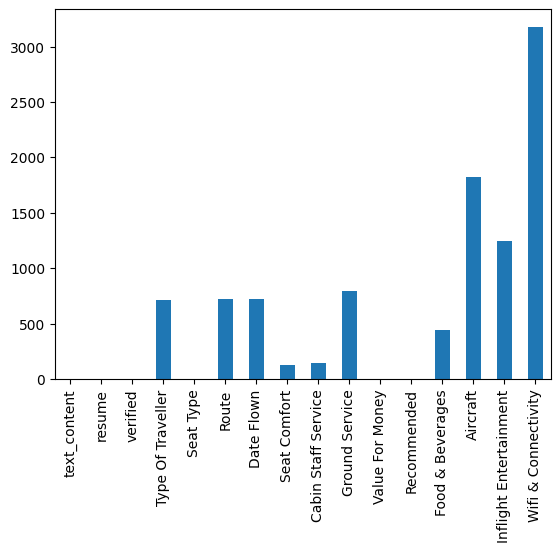

In [57]:
data.isna().sum().plot(kind='bar')

In [59]:
data.drop(['Aircraft', 'Inflight Entertainment', 'Wifi & Connectivity'],axis=1,inplace=True)

In [60]:
data.columns

Index(['text_content', 'resume', 'verified', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service',
       'Ground Service', 'Value For Money', 'Recommended', 'Food & Beverages'],
      dtype='object')

In [61]:
data.to_csv('data_not_cleand.csv')

In [62]:
data.dropna(axis=0,inplace=True)
data.shape

(2696, 13)

In [64]:
data

,text_content,resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages
1,"✅ Trip Verified | The service was rude, full...","""full of attitude to me""",True,Business,Premium Economy,London to New York,January 2025,1 stars,1 stars,5 stars,1 stars,no,1 stars
2,✅ Trip Verified | This flight was a joke. Th...,"""service was outrageous""",True,Business,Business Class,Chambery to London,January 2025,1 stars,1 stars,1 stars,1 stars,no,2 stars
3,✅ Trip Verified | This time British Airways ...,"""managed to get everything right""",True,Business,Premium Economy,Gatwick to Antigua,March 2025,5 stars,5 stars,5 stars,5 stars,yes,4 stars
4,"✅ Trip Verified | The seats were excellent, ...","""The seats were excellent""",True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5 stars,4 stars,4 stars,5 stars,yes,3 stars
5,✅ Trip Verified | After the nightmare of get...,"""the crew were awful""",True,Couple Leisure,Business Class,Nairobi to London,February 2025,4 stars,1 stars,4 stars,3 stars,no,2 stars
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,I flew out on the 8th June 2015 and all I can ...,British Airways customer review,False,Couple Leisure,Economy Class,London to Turkey,June 2015,5 stars,5 stars,5 stars,5 stars,yes,5 stars
3138,I fly with this airline almost every other wee...,British Airways customer review,False,Solo Leisure,Economy Class,Abu Dhabi to Muscat,June 2015,5 stars,5 stars,4 stars,5 stars,yes,3 stars
3139,"Ended up on a 25-year-old 747, the second-olde...",British Airways customer review,False,Solo Leisure,Economy Class,LHR to YYZ,May 2015,3 stars,4 stars,4 stars,4 stars,yes,4 stars
3140,We were boarded quickly but suffered a weather...,British Airways customer review,False,Couple Leisure,Economy Class,LGW to VCE,June 2015,3 stars,5 stars,4 stars,4 stars,yes,3 stars


In [68]:
ratings_col = ['Seat Comfort', 'Cabin Staff Service',
       'Ground Service', 'Value For Money', 'Food & Beverages']

In [69]:
df = data.copy()

In [70]:
for col in ratings_col :
    df[col] = df[col].str.extract(r'([1-9])')

In [71]:
df.head()

,text_content,resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages
1,"✅ Trip Verified | The service was rude, full...","""full of attitude to me""",True,Business,Premium Economy,London to New York,January 2025,1,1,5,1,no,1
2,✅ Trip Verified | This flight was a joke. Th...,"""service was outrageous""",True,Business,Business Class,Chambery to London,January 2025,1,1,1,1,no,2
3,✅ Trip Verified | This time British Airways ...,"""managed to get everything right""",True,Business,Premium Economy,Gatwick to Antigua,March 2025,5,5,5,5,yes,4
4,"✅ Trip Verified | The seats were excellent, ...","""The seats were excellent""",True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5,4,4,5,yes,3
5,✅ Trip Verified | After the nightmare of get...,"""the crew were awful""",True,Couple Leisure,Business Class,Nairobi to London,February 2025,4,1,4,3,no,2


In [72]:
df['Recommended'] = df['Recommended'].apply(lambda x : 0 if x == 'no' else 1)
df.head()

,text_content,resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages
1,"✅ Trip Verified | The service was rude, full...","""full of attitude to me""",True,Business,Premium Economy,London to New York,January 2025,1,1,5,1,0,1
2,✅ Trip Verified | This flight was a joke. Th...,"""service was outrageous""",True,Business,Business Class,Chambery to London,January 2025,1,1,1,1,0,2
3,✅ Trip Verified | This time British Airways ...,"""managed to get everything right""",True,Business,Premium Economy,Gatwick to Antigua,March 2025,5,5,5,5,1,4
4,"✅ Trip Verified | The seats were excellent, ...","""The seats were excellent""",True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5,4,4,5,1,3
5,✅ Trip Verified | After the nightmare of get...,"""the crew were awful""",True,Couple Leisure,Business Class,Nairobi to London,February 2025,4,1,4,3,0,2


### **text cleaning**

In [73]:
df.rename(columns={'text_content':'review','resume':'review_resume'},inplace=True)

In [74]:
df.head()

,review,review_resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages
1,"✅ Trip Verified | The service was rude, full...","""full of attitude to me""",True,Business,Premium Economy,London to New York,January 2025,1,1,5,1,0,1
2,✅ Trip Verified | This flight was a joke. Th...,"""service was outrageous""",True,Business,Business Class,Chambery to London,January 2025,1,1,1,1,0,2
3,✅ Trip Verified | This time British Airways ...,"""managed to get everything right""",True,Business,Premium Economy,Gatwick to Antigua,March 2025,5,5,5,5,1,4
4,"✅ Trip Verified | The seats were excellent, ...","""The seats were excellent""",True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5,4,4,5,1,3
5,✅ Trip Verified | After the nightmare of get...,"""the crew were awful""",True,Couple Leisure,Business Class,Nairobi to London,February 2025,4,1,4,3,0,2


In [75]:
df['review'] = df['review'].str.replace(r'[^A-Za-z\s]', '', regex=True).str.strip()

In [76]:
df['review_resume'] = df['review_resume'].str.replace(r'[^A-Za-z\s]','',regex=True).str.strip()

In [77]:
df['review_resume'] = df['review_resume'].str.lower()
df['review'] = df['review'].str.lower()

In [78]:
df

,review,review_resume,verified,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages
1,trip verified the service was rude full of ...,full of attitude to me,True,Business,Premium Economy,London to New York,January 2025,1,1,5,1,0,1
2,trip verified this flight was a joke there ...,service was outrageous,True,Business,Business Class,Chambery to London,January 2025,1,1,1,1,0,2
3,trip verified this time british airways man...,managed to get everything right,True,Business,Premium Economy,Gatwick to Antigua,March 2025,5,5,5,5,1,4
4,trip verified the seats were excellent with...,the seats were excellent,True,Couple Leisure,Premium Economy,Mumbai to London,February 2025,5,4,4,5,1,3
5,trip verified after the nightmare of gettin...,the crew were awful,True,Couple Leisure,Business Class,Nairobi to London,February 2025,4,1,4,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,i flew out on the th june and all i can say i...,british airways customer review,False,Couple Leisure,Economy Class,London to Turkey,June 2015,5,5,5,5,1,5
3138,i fly with this airline almost every other wee...,british airways customer review,False,Solo Leisure,Economy Class,Abu Dhabi to Muscat,June 2015,5,5,4,5,1,3
3139,ended up on a yearold the secondoldest in bas...,british airways customer review,False,Solo Leisure,Economy Class,LHR to YYZ,May 2015,3,4,4,4,1,4
3140,we were boarded quickly but suffered a weather...,british airways customer review,False,Couple Leisure,Economy Class,LGW to VCE,June 2015,3,5,4,4,1,3


In [79]:
df['year'] = df['Date Flown'].str.split(' ').str[1]
df['Month'] = df['Date Flown'].str.split(' ').str[0]

In [80]:
df.drop('Date Flown',axis=1,inplace=True)

In [81]:
df.head()

,review,review_resume,verified,Type Of Traveller,Seat Type,Route,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages,year,Month
1,trip verified the service was rude full of ...,full of attitude to me,True,Business,Premium Economy,London to New York,1,1,5,1,0,1,2025,January
2,trip verified this flight was a joke there ...,service was outrageous,True,Business,Business Class,Chambery to London,1,1,1,1,0,2,2025,January
3,trip verified this time british airways man...,managed to get everything right,True,Business,Premium Economy,Gatwick to Antigua,5,5,5,5,1,4,2025,March
4,trip verified the seats were excellent with...,the seats were excellent,True,Couple Leisure,Premium Economy,Mumbai to London,5,4,4,5,1,3,2025,February
5,trip verified after the nightmare of gettin...,the crew were awful,True,Couple Leisure,Business Class,Nairobi to London,4,1,4,3,0,2,2025,February


In [82]:
df['year'] = pd.to_datetime(df['year'],format='%Y').dt.strftime('%Y')

In [83]:
df['verified'] = df['verified'].apply(lambda x : 0 if x == False else 1)

In [84]:
df

,review,review_resume,verified,Type Of Traveller,Seat Type,Route,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages,year,Month
1,trip verified the service was rude full of ...,full of attitude to me,1,Business,Premium Economy,London to New York,1,1,5,1,0,1,2025,January
2,trip verified this flight was a joke there ...,service was outrageous,1,Business,Business Class,Chambery to London,1,1,1,1,0,2,2025,January
3,trip verified this time british airways man...,managed to get everything right,1,Business,Premium Economy,Gatwick to Antigua,5,5,5,5,1,4,2025,March
4,trip verified the seats were excellent with...,the seats were excellent,1,Couple Leisure,Premium Economy,Mumbai to London,5,4,4,5,1,3,2025,February
5,trip verified after the nightmare of gettin...,the crew were awful,1,Couple Leisure,Business Class,Nairobi to London,4,1,4,3,0,2,2025,February
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,i flew out on the th june and all i can say i...,british airways customer review,0,Couple Leisure,Economy Class,London to Turkey,5,5,5,5,1,5,2015,June
3138,i fly with this airline almost every other wee...,british airways customer review,0,Solo Leisure,Economy Class,Abu Dhabi to Muscat,5,5,4,5,1,3,2015,June
3139,ended up on a yearold the secondoldest in bas...,british airways customer review,0,Solo Leisure,Economy Class,LHR to YYZ,3,4,4,4,1,4,2015,May
3140,we were boarded quickly but suffered a weather...,british airways customer review,0,Couple Leisure,Economy Class,LGW to VCE,3,5,4,4,1,3,2015,June


In [85]:
df.to_csv('df_cleaned.csv')

In [86]:
df.shape

(2696, 14)